<a href="https://colab.research.google.com/github/GabyDs/EjerciciosInteligenciaComputacional/blob/main/Ejercicio5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preprocesamiento de datos

In [1]:
# Importación, visualización, manipulación de datos
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Transformación de datos
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report

# RNA
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

# Visualización de resultados
from sklearn.metrics import confusion_matrix

In [2]:
#!unzip datos_acv.zip

In [3]:
# Lectura del dataset
dataset = pd.read_csv("datos_acv.csv")

In [4]:
# Para visualizar tipos de datos
# Además, se evidencian valores nulos
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  5110 non-null   int64  
 1   genero              5110 non-null   object 
 2   edad                5110 non-null   float64
 3   hipertension        5110 non-null   int64  
 4   enfermedad_corazon  5110 non-null   int64  
 5   casado_alguna_vez   5110 non-null   int64  
 6   tipo_trabajo        5110 non-null   object 
 7   tipo_residencia     5110 non-null   object 
 8   nivel_glucosa       5110 non-null   float64
 9   imc                 4909 non-null   float64
 10  estado_fumador      5110 non-null   object 
 11  apoplejia           5110 non-null   int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 479.2+ KB


In [5]:
# Para obtener los valores nulos directamente
dataset.isna().sum()

id                      0
genero                  0
edad                    0
hipertension            0
enfermedad_corazon      0
casado_alguna_vez       0
tipo_trabajo            0
tipo_residencia         0
nivel_glucosa           0
imc                   201
estado_fumador          0
apoplejia               0
dtype: int64

In [6]:
# Categorías disponibles en las variables categóricas
for col in dataset.columns:
    if dataset[col].dtype == 'object' or (dataset[col].dtype == 'int64' and col != 'id'):
        print(col,"->", dataset[col].unique())

genero -> ['hombre' 'mujer' 'otro']
hipertension -> [0 1]
enfermedad_corazon -> [1 0]
casado_alguna_vez -> [1 0]
tipo_trabajo -> ['privado' 'autonomo' 'gubernamental' 'con_niños' 'nunca_trabajo']
tipo_residencia -> ['urbano' 'rural']
estado_fumador -> ['fumaba' 'nunca' 'fuma' 'desconocido']
apoplejia -> [1 0]


<Axes: ylabel='tipo_trabajo'>

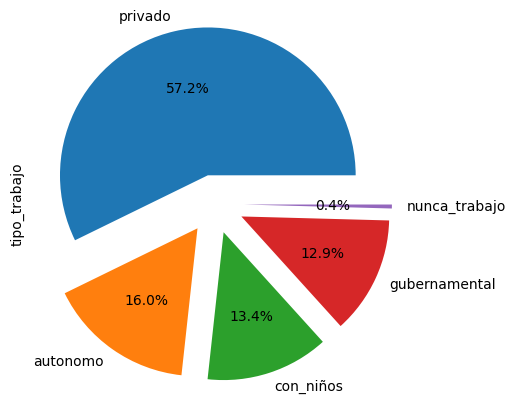

In [7]:
# Ejemplo de gráfica para una idea de las distribuciones
dataset['tipo_trabajo'].value_counts().plot.pie(autopct='%1.1f%%', explode=[0.2, 0.2, 0.2, 0.2, 0.2])

In [8]:
# Para quitar columnas del dataset
dataset.pop('id')

# Para quitar filas según un criterio
dataset = dataset[dataset.genero != 'otro']  # Nos quedamos con hombre y mujer solamente
dataset = dataset[dataset.tipo_trabajo != 'Never_worked'] # Quitamos los que nunca trabajaron, probablemente sean muy jóvenes

In [9]:
# Ejemplo de tratamiento de valores faltantes, se reemplazan por la media de la columna. (No siempre es conveniente esto, analizar)
dataset['imc'].fillna(dataset['imc'].median(), inplace=True)
# Se vuelve a contabilizar para testear la actualización
dataset.isna().sum()

genero                0
edad                  0
hipertension          0
enfermedad_corazon    0
casado_alguna_vez     0
tipo_trabajo          0
tipo_residencia       0
nivel_glucosa         0
imc                   0
estado_fumador        0
apoplejia             0
dtype: int64

In [10]:
# Aplicamos un filtro para evidencias estos valores faltantes en la información básica del dataset
dataset['estado_fumador'].replace(r'desconocido', np.nan, inplace = True)
dataset.isna().sum()        # Se puede hacer algo con estos casos

genero                   0
edad                     0
hipertension             0
enfermedad_corazon       0
casado_alguna_vez        0
tipo_trabajo             0
tipo_residencia          0
nivel_glucosa            0
imc                      0
estado_fumador        1544
apoplejia                0
dtype: int64

<ipython-input-11-f53867162055>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data=dataset.corr(), annot=True)


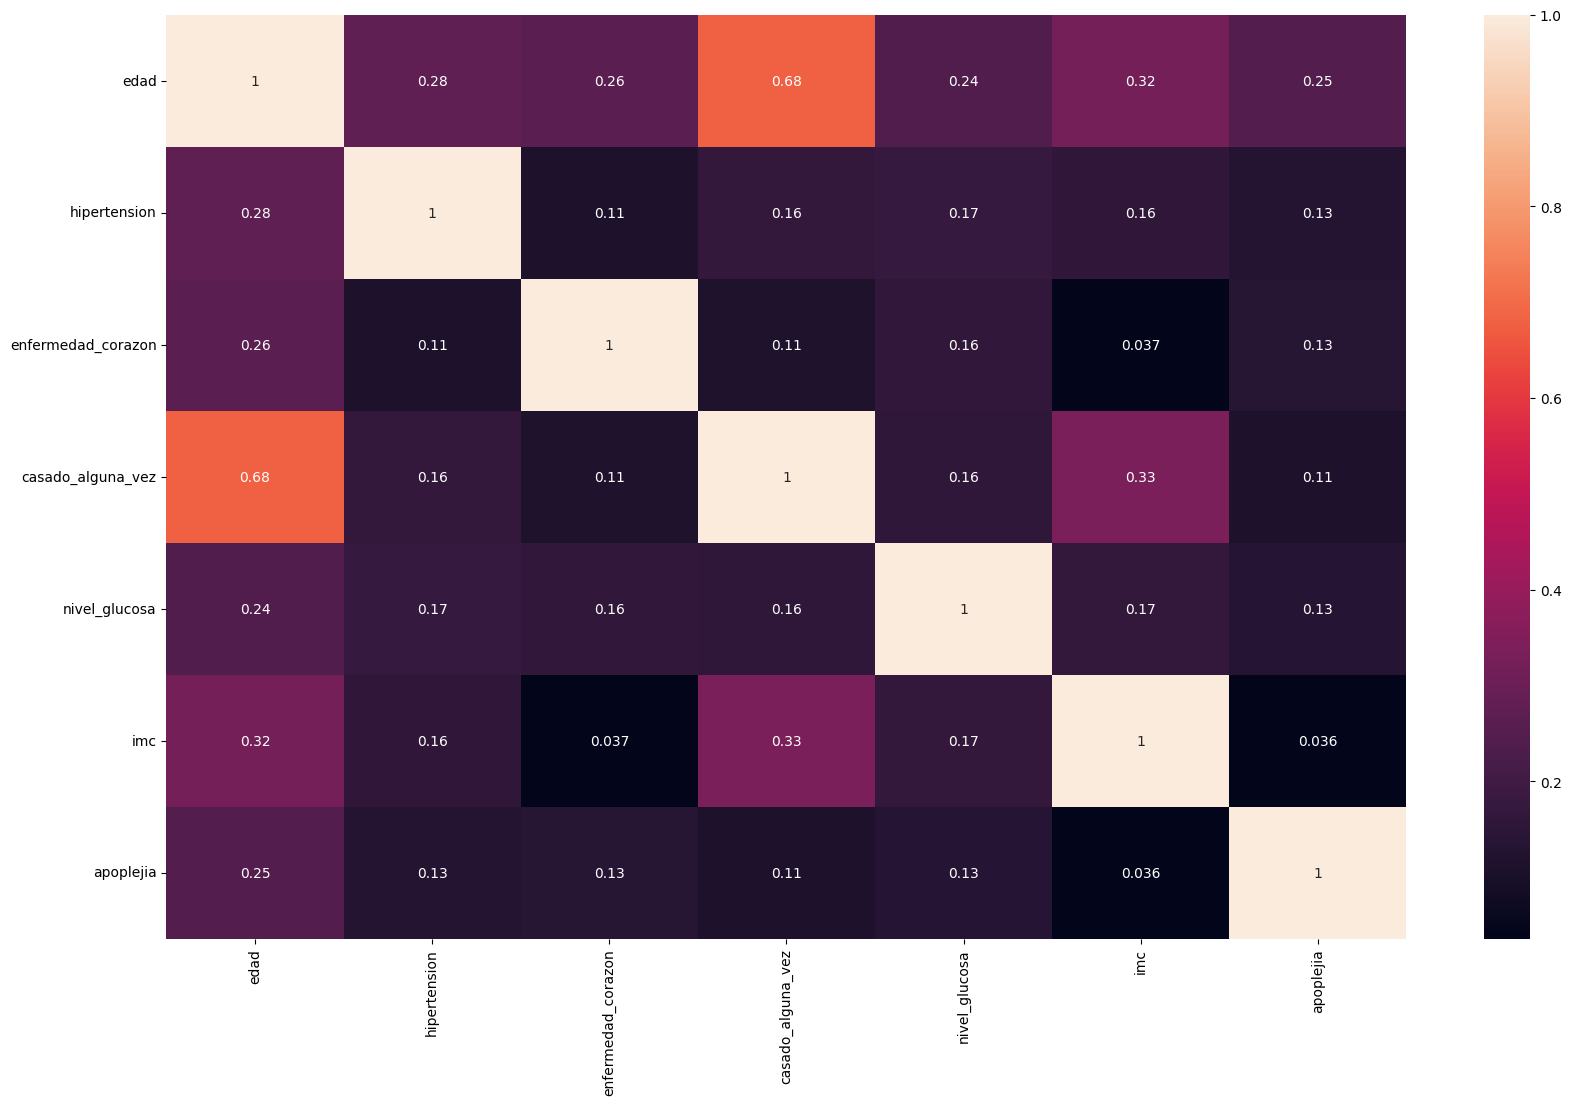

In [11]:
# Mapa de correlaciones, se puede observar dependencias entre columnas. Permite descartar descriptores que no aportan información nueva por ejemplo (resta costo computacional, etc.)
sns.heatmap(data=dataset.corr(), annot=True)

fig=plt.gcf()
fig.set_size_inches(20,12)
plt.show()

# En este caso por ejemplo, se observa una fuerte relación entre la edad y si estuvieron casados.

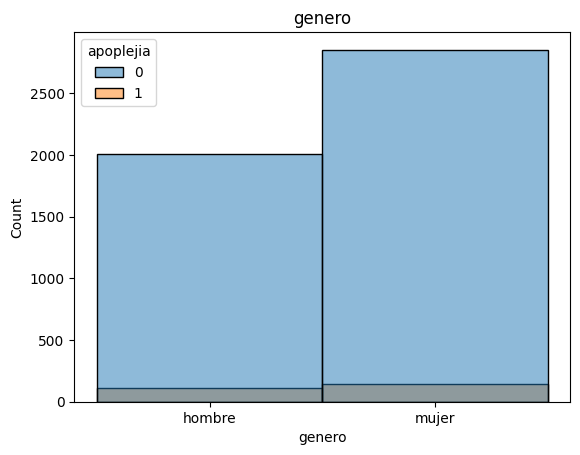

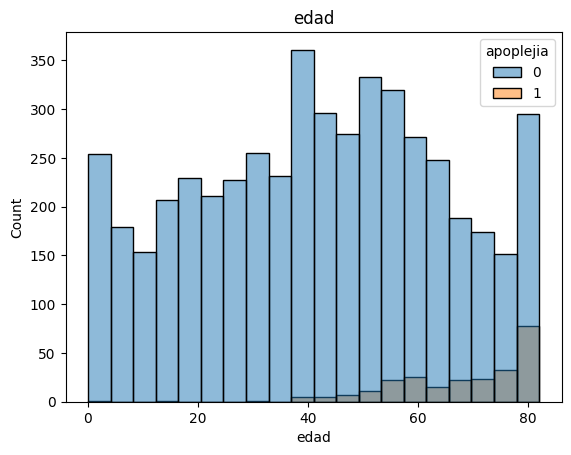

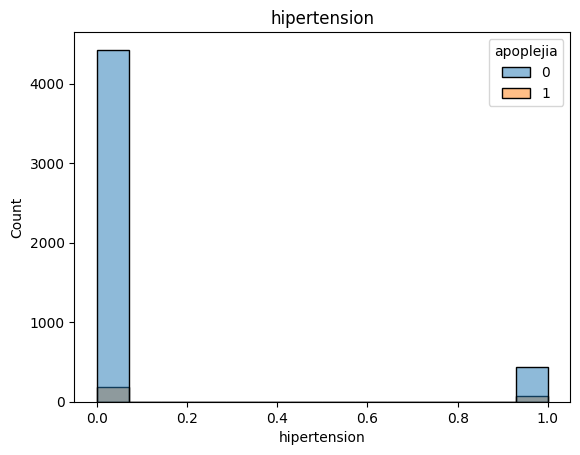

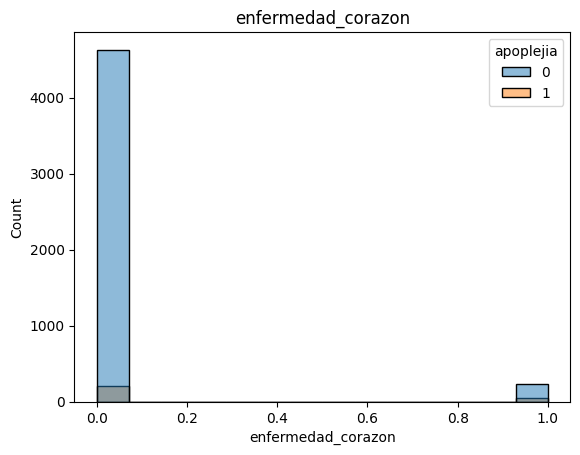

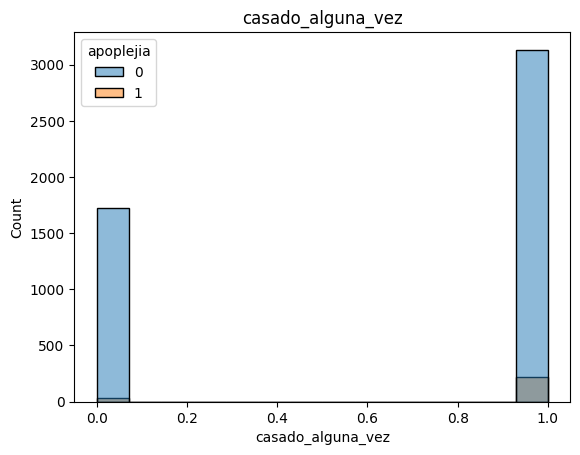

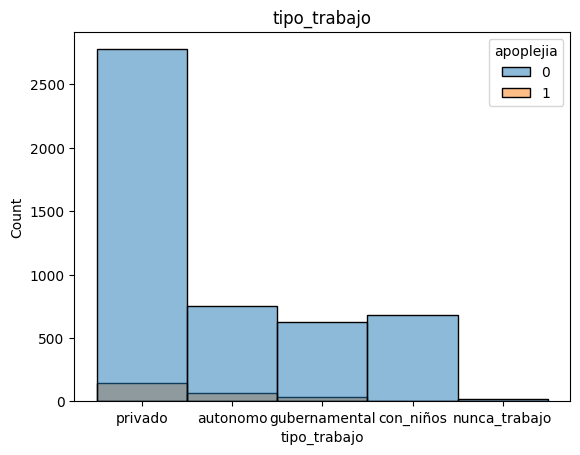

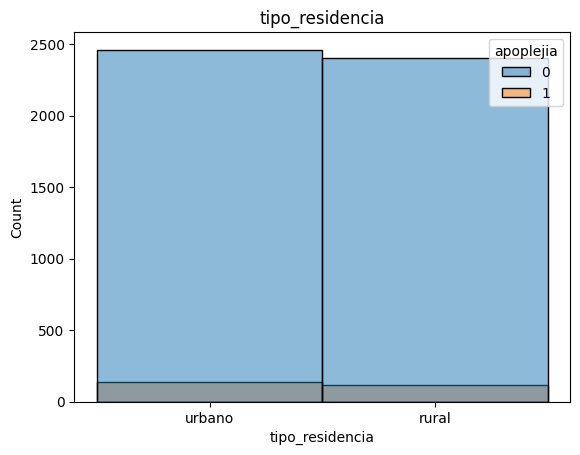

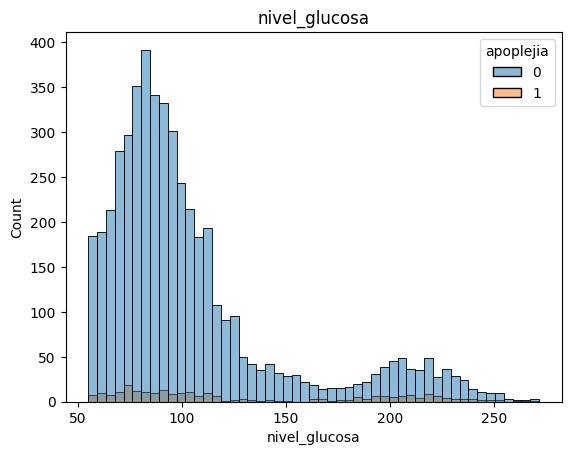

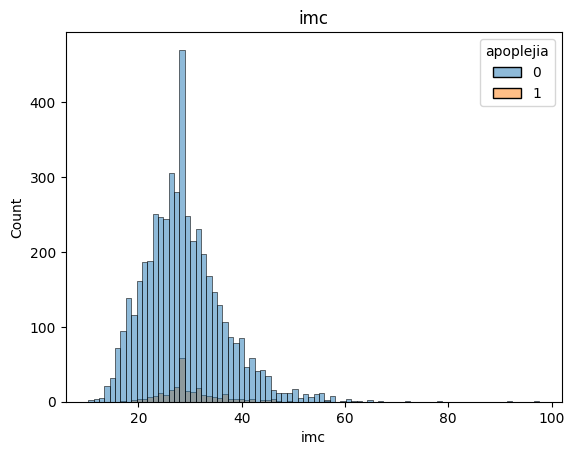

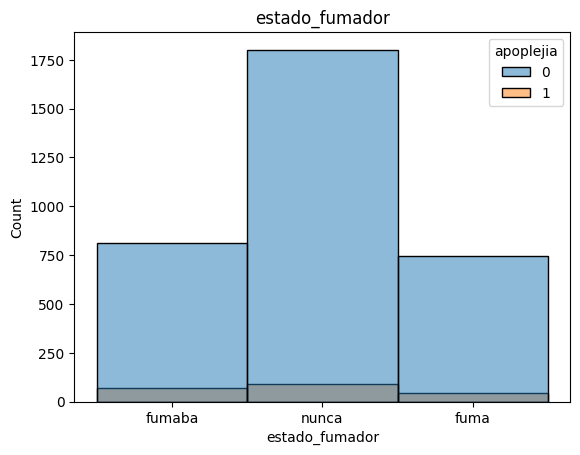

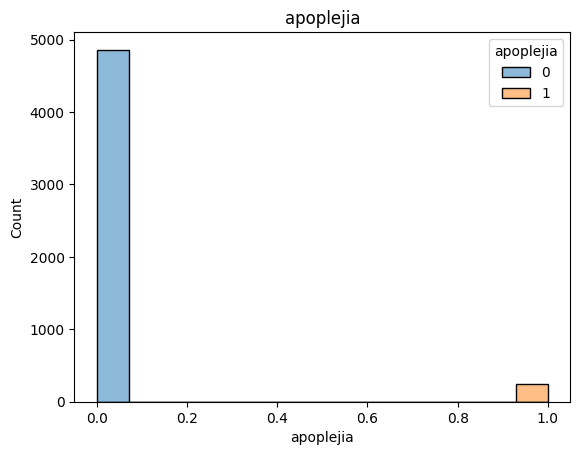

In [12]:
# Más ejemplos de gráficas. Distribuciones respecto a la salida
for col in dataset.columns:
    plt.title(col)
    sns.histplot(data=dataset, x = col, hue='apoplejia')
    plt.show()

In [13]:
# Tratamiento de los datos y división del dataset

# Definición de la columna de salida esperada (aprendizaje supervisado)
y_data = dataset.pop('apoplejia')
y_data = np.asarray(y_data).astype('float32')

# Preprocesamiento
# Se codifica numéricamente las categorías definidas con etiquetas. Ej.: en lugar de “urbano” y “rural” en tipo_residencia, queda 0 y 1.
le = LabelEncoder()
# Similar al proceso de escalado en el TP8, mejora el rendimiento.
ss = StandardScaler()

for col in dataset.columns:
    if dataset[col].dtype == 'object':
        # Si son columnas 'object', se codifican como numéricas. En esencia, siguen siendo categóricas.
        dataset[col] = le.fit_transform(dataset[col])
    elif dataset[col].dtype == 'int64':
        # Conversión a arreglo de numpy, más velocidad en el procesamiento
        dataset[col] = np.asarray(dataset[col]).astype('float64')
    else:
        # Escalado
        dataset[col] = ss.fit_transform(dataset[[col]])

In [14]:
# Para tener el estado actual de la cantidad de datos resultantes en el procesamiento previo. Si se imputan las filas con N/A, disminuye bastante por ej.
print("Tamaño actual - Salida:", y_data.shape)

Tamaño actual - Salida: (5109,)


In [15]:
x_data = np.asarray(dataset) # Esto se puede hacer directamente porque para y_train se usó pop sobre el dataframe.
print("Tamaño actual - Entrada:", x_data.shape) # Es importante que el tamaño sea consistente entre X e Y.

Tamaño actual - Entrada: (5109, 10)


# RNA Topologia manual

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=1)

In [17]:
# Ejemplo para balancear datos
from imblearn.over_sampling import SMOTE
sm = SMOTE()

x_train, y_train = sm.fit_resample(x_train, y_train)

num_zeros = (y_train == 0).sum()
num_ones = (y_train == 1).sum()
print(" Cantidad '0': {} \n Cantidad '1': {}".format(num_zeros, num_ones))
# Ahora se equiparan ambas salidas. Investigar como opera esta clase
# En resumen, genera nuevas muestras a partir de las existentes para obtener más entradas de la clase desbalanceada
# La cantidad final resulta igual a la cantidad de la clase mayoritaria previo al resample.

 Cantidad '0': 3410 
 Cantidad '1': 3410


In [18]:
x_train.shape[1] # Cantidad de entradas

10

In [78]:
# Diseñar el modelo

model = models.Sequential()

# Capa de entrada
model.add(layers.Dense(64, activation='relu', input_shape=(x_train.shape[1],))) # Es importante el tamaño de la capa de entrada
model.add(layers.Dropout(0.2))

# Agregamos capas ocultas, se agregara de a una, con 64, 128 y 256 neuronas
# para asi guardar la metrica obtenida

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))

# Capa de salida
model.add(layers.Dense(1, activation='sigmoid')) # sigmoid para obtener una salida binaria

# Para visualizar la topología resultante
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 64)                704       
                                                                 
 dropout_14 (Dropout)        (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 64)                4160      
                                                                 
 dropout_15 (Dropout)        (None, 64)                0         
                                                                 
 dense_18 (Dense)            (None, 128)               8320      
                                                                 
 dropout_16 (Dropout)        (None, 128)               0         
                                                                 
 dense_19 (Dense)            (None, 256)              

In [35]:
# Se define el optimizador a utilizar, tasa de aprendizaje y otros argumentos a utilizar. Por ej: la métrica de referencia será el accuracy
model.compile(optimizer=optimizers.Adam(learning_rate=2e-4), loss='binary_crossentropy', metrics=['Accuracy', 'Recall', 'Precision'])

# Se entrena el modelo y se guardan los resultados. Se define un límite de épocas y el tamaño de lotes a usar.
# El máximo para el lote es la cantidad de datos disponibles, conviene utilizar uno tal que permita un número significativo de mezclas a lo largo de las épocas.
history = model.fit(x_train, y_train, epochs=10, batch_size=128)

Epoch 1/10
54/54 [==============================] - 5s 17ms/step - loss: 0.4455 - Accuracy: 0.7909 - recall: 0.8889 - precision: 0.7433
Epoch 2/10
54/54 [==============================] - 1s 13ms/step - loss: 0.4418 - Accuracy: 0.7918 - recall: 0.8918 - precision: 0.7432
Epoch 3/10
54/54 [==============================] - 1s 16ms/step - loss: 0.4421 - Accuracy: 0.7889 - recall: 0.8865 - precision: 0.7417
Epoch 4/10
54/54 [==============================] - 1s 10ms/step - loss: 0.4368 - Accuracy: 0.7971 - recall: 0.8853 - precision: 0.7525
Epoch 5/10
54/54 [==============================] - 0s 9ms/step - loss: 0.4362 - Accuracy: 0.7965 - recall: 0.8971 - precision: 0.7468
Epoch 6/10
54/54 [==============================] - 0s 8ms/step - loss: 0.4290 - Accuracy: 0.8007 - recall: 0.8935 - precision: 0.7536
Epoch 7/10
54/54 [==============================] - 0s 8ms/step - loss: 0.4372 - Accuracy: 0.7943 - recall: 0.8886 - precision: 0.7476
Epoch 8/10
54/54 [==============================] -

In [97]:
# agregamos el accuracy obtenido en cada ejecucion
# por cada oculta que se añada al modelo
lista_accuracy = []
lista_recall = []
lista_precision = []
lista_f1 = []

In [98]:
def cargardato():
  # Evaluación del modelo sobre el set para test
  result = model.evaluate(x_test, y_test) # Devuelve pérdida y accuracy (segun la metrica)
  #recall = round(result[1], 4)
  #lista_recall.append(recall)

  lista_accuracy.append(round(result[1], 4))
  lista_recall.append(round(result[2], 4))
  lista_precision.append(round(result[3], 4))

  f1 = 2 * ((result[3] * result[2] ) / (result[3] + result[2]))
  lista_f1.append(round(f1, 4))

In [99]:
import numpy as np

valores = np.linspace(2e-4, 0.1, 5)

for valor in valores:
  model.compile(optimizer=optimizers.Adam(learning_rate=valor), loss='binary_crossentropy', metrics=['Accuracy', 'Recall', 'Precision'])
  history = model.fit(x_train, y_train, epochs=20, batch_size=128)
  cargardato()


Epoch 1/20
54/54 [==============================] - 2s 6ms/step - loss: 0.2349 - Accuracy: 0.9076 - recall: 0.9484 - precision: 0.8769
Epoch 2/20
54/54 [==============================] - 0s 6ms/step - loss: 0.2360 - Accuracy: 0.9031 - recall: 0.9422 - precision: 0.8738
Epoch 3/20
54/54 [==============================] - 0s 6ms/step - loss: 0.2376 - Accuracy: 0.9021 - recall: 0.9487 - precision: 0.8678
Epoch 4/20
54/54 [==============================] - 0s 6ms/step - loss: 0.2373 - Accuracy: 0.9072 - recall: 0.9478 - precision: 0.8766
Epoch 5/20
54/54 [==============================] - 0s 6ms/step - loss: 0.2360 - Accuracy: 0.9089 - recall: 0.9516 - precision: 0.8768
Epoch 6/20
54/54 [==============================] - 0s 5ms/step - loss: 0.2280 - Accuracy: 0.9107 - recall: 0.9490 - precision: 0.8815
Epoch 7/20
54/54 [==============================] - 0s 5ms/step - loss: 0.2260 - Accuracy: 0.9072 - recall: 0.9507 - precision: 0.8746
Epoch 8/20
54/54 [==============================] - 0s 

In [ ]:
# Barrido de epocas 1 ~ 100
for epoch in range(1, 101, 20):
  # Se define el optimizador a utilizar, tasa de aprendizaje y otros argumentos a utilizar. Por ej: la métrica de referencia será el accuracy
  model.compile(optimizer=optimizers.Adam(learning_rate=2e-4), loss='binary_crossentropy', metrics=['Accuracy', 'Recall', 'Precision'])

  # Se entrena el modelo y se guardan los resultados. Se define un límite de épocas y el tamaño de lotes a usar.
  # El máximo para el lote es la cantidad de datos disponibles, conviene utilizar uno tal que permita un número significativo de mezclas a lo largo de las épocas.
  history = model.fit(x_train, y_train, epochs=epoch+1, batch_size=128)

  cargardato()

In [100]:
print(lista_accuracy, lista_recall, lista_precision, lista_f1)

[0.8291, 0.7521, 0.6464, 0.7312, 0.8147] [0.2651, 0.4337, 0.8313, 0.8193, 0.5422] [0.0987, 0.0976, 0.1156, 0.1462, 0.1546] [0.1438, 0.1593, 0.2029, 0.2482, 0.2406]


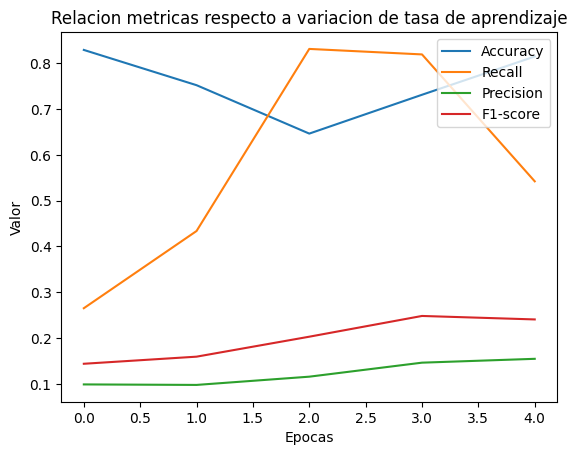

In [101]:
metricas = [lista_accuracy, lista_recall, lista_precision, lista_f1]
nombres = ['Accuracy', 'Recall', 'Precision', 'F1-score']

nombre_y_metricas = dict(zip(nombres, metricas))

for nombre, metrica in nombre_y_metricas.items():
  plt.plot(metrica)
  plt.title('Relacion metricas respecto a variacion de tasa de aprendizaje')
  plt.xlabel('Epocas')
  plt.ylabel('Valor')
  plt.legend(nombres, loc="upper right")

Text(0, 0.5, 'Recall')

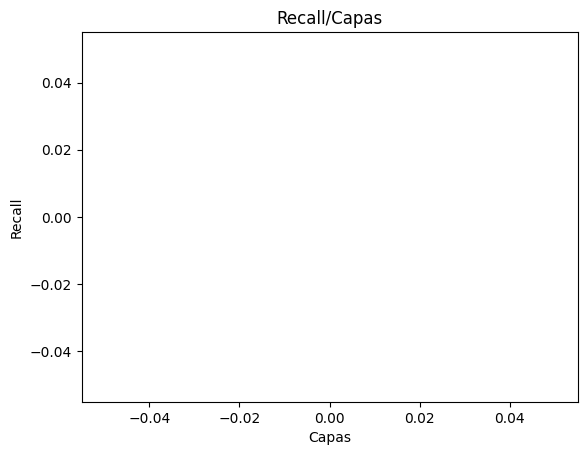

In [24]:
plt.plot(lista_recall)
plt.title('Recall/Capas')
plt.xlabel('Capas')
plt.ylabel('Recall')

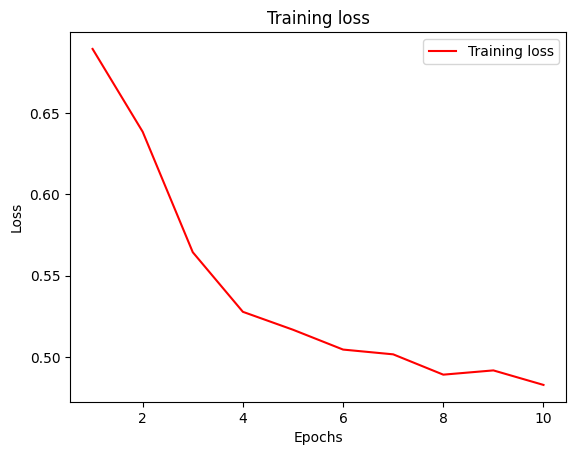

In [26]:
history_dict = history.history
loss_values = history_dict['loss']
epochs = range(1, len(history_dict['recall']) + 1)
plt.plot(epochs, loss_values, 'r', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

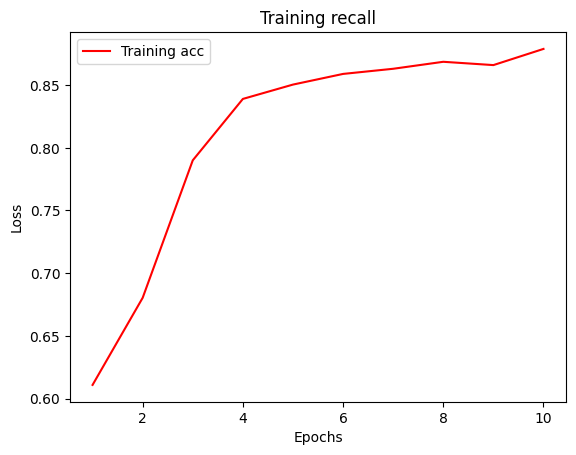

In [27]:
plt.clf()
acc_values = history_dict['recall']
plt.plot(epochs, history_dict['recall'], 'r', label='Training acc')
plt.title('Training recall')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [28]:
# Obtención de métricas (respecto al set de test siempre)
y_pred = model.predict(x_test)

# Se redondea la predicción de la salida
y_pred = [1.0 if p > 0.5 else 0 for p in y_pred]

print(classification_report(y_test, y_pred))
# Notar que hay un lindo problema de desbalance en los datos, muchos para "0" (gente que no tuvo ACV) y pocos para "1" (si ACV)
# Es probable que el modelo pretenda decir "0" casi siempre, porque esto es la salida "fácil" para mejorar el accuracy.
# Hay muchas técnicas para "balancear" un conjunto de datos desparejo, y así evitar la tendencia del modelo en el entrenamiento.

48/48 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         0.0       0.99      0.66      0.79      1450
         1.0       0.13      0.87      0.22        83

    accuracy                           0.67      1533
   macro avg       0.56      0.76      0.50      1533
weighted avg       0.94      0.67      0.76      1533



In [29]:
# Visualización de los resultados utilizando la matriz de confusión
confusion_matrix(y_test, y_pred)
# Ahora se confirma la hipótesis de que probablemente la red aprende a decir que no hay ACV para maximizar el accuracy

array([[951, 499],
       [ 11,  72]])